In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from lema.core.types.base_dataset import AlpacaDataset

In [41]:
%load_ext line_profiler
%load_ext memory_profiler

### 1. Listing Supported Datasets

In [3]:
import inspect
import sys


def list_supported_datasets():
    """List all supported datasets and their corresponding dataset classes."""
    root_module = "lema.core.types.base_dataset"

    dataset_classes = inspect.getmembers(sys.modules[root_module], inspect.isclass)

    for cls_name, cls_obj in dataset_classes:
        if (
            hasattr(cls_obj, "supported_datasets")
            and cls_obj.supported_datasets is not None
        ):
            for dataset_name in cls_obj.supported_datasets:
                print(f"'{dataset_name}' -> {cls_name}")


list_supported_datasets()

'tatsu-lab/alpaca' -> AlpacaDataset
'yahma/alpaca-cleaned' -> AlpacaDataset
'nvidia/ChatQA-Training-Data' -> ChatQADataset


### 2. Loading Datasets

We load the alpaca dataset. Since multiple variants can be registered in the HuggingFace hub, by default we use `Dataset.default`.

In [4]:
%%time

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

/Users/oussamaelachqar/miniconda3/envs/dev/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CPU times: user 79.8 ms, sys: 12.8 ms, total: 92.6 ms
Wall time: 275 ms


In [5]:
%%time

dataset = AlpacaDataset(tokenizer=tokenizer)

print(f"Using: {dataset.dataset_name_or_path}")

Using: tatsu-lab/alpaca
CPU times: user 161 ms, sys: 53.6 ms, total: 215 ms
Wall time: 2.17 s


Alternatively, you can pass a custom HuggingFace hub identifier. You can find a list of supported datasets in `Dataset.supported_datasets`

In [6]:
%%time

dataset = AlpacaDataset(
    dataset_name_or_path="yahma/alpaca-cleaned", tokenizer=tokenizer
)

print(f"Using: {dataset.dataset_name_or_path}")

Using: yahma/alpaca-cleaned
CPU times: user 150 ms, sys: 31 ms, total: 181 ms
Wall time: 2.06 s


Under the hood, the dataset is downloaded from the HuggingFace hub, and cached in the `~/.cache/huggingface/datasets` directory.

When instantiating the class, the dataset is loaded in memory. This is acceptable with small datasets, but for larger datasets, we can either use `IterableDataset` for streaming batch from disk, or shard per worker rank (so that Memory // N_GPUs).

Finally, you can also load a dataset from a local `jsonl` or `parquet` file.

In [40]:
# dataset = LemaSftDataset(dataset_name_or_path="./sft.jsonl", tokenizer=tokenizer)
# dataset = LemaSftDataset(dataset_name_or_path="./sft.parquet", tokenizer=tokenizer)

### 3. Iterating Over Dataset

In [7]:
print(f"Number of examples: {len(dataset)}")

Number of examples: 51760


Given everything is loaded into memory, we can randomly access any row in the dataset:

In [8]:
%%timeit

dataset[42]


No chat template is defined for this tokenizer - using the default template for the GPT2TokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



291 µs ± 6.12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


We can iterate over the dataset to get the examples, either manually or using a DataLoader.

In [9]:
%%time

# Manual iteration
[dataset[i] for i in range(len(dataset))];

CPU times: user 17.5 s, sys: 214 ms, total: 17.7 s
Wall time: 17.8 s


In [10]:
%%time

# With a pytorch data loader
loader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
list(loader);

CPU times: user 18.7 s, sys: 93.2 ms, total: 18.8 s
Wall time: 18.9 s


We can also use any library from the pytorch ecosystem, e.g. `torchtext`, `torchdata`, etc.

In [23]:
from torchdata.stateful_dataloader import StatefulDataLoader

loader = StatefulDataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)

In [26]:
loader.state_dict()

{'_index_sampler_state': {'samples_yielded': 1},
 '_sampler_iter_state': None,
 '_sampler_iter_yielded': 1,
 '_num_yielded': 1,
 '_IterableDataset_len_called': None,
 '_shared_seed': None,
 'fetcher_state': None,
 'dataset_state': None,
 '_iterator_finished': False}

In [25]:
next(iter(loader));

### 4. Accessing Individual Examples

Alpaca is a "Supervised Finetuning Dataset". It contains instructions, user inputs, and model outputs. An SFT dataset has the following methods:

**Base Map Dataset**
```python
dataset[0] -> model inputs  # pytorch convention
dataset.raw(0) -> raw data  # lema convention
```
**Base SFT Dataset**
```python
dataset.conversation(0) -> conversation # model independent
dataset.prompt(0) -> prompt  # dependends on the tokenizer
```

In [11]:
# Raw data (pd.Series, dict), as defined by the dataset authors
dataset.raw(0)

output         1. Eat a balanced and nutritious diet: Make su...
input                                                           
instruction                 Give three tips for staying healthy.
Name: 0, dtype: object

In [12]:
# Convert to standard Lema SFT format (lema.core.types.Conversation)
dataset.conversation(0).messages

[Message(id=None, content='Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.', role=<Role.SYSTEM: 'system'>),
 Message(id=None, content='Give three tips for staying healthy.', role=<Role.USER: 'user'>),
 Message(id=None, content='1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive f

In [13]:
# Convert to model prompt (str). This include the model's chat temlate,
# EOS tokens for inference/generation, etc.
dataset.prompt(0)

'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.<|endoftext|>Give three tips for staying healthy.<|endoftext|>1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.<|endoftext|>'

In [14]:
# What is fed to the model.forward (dict)
dataset[0]

{'input_ids': tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    11, 20312,
           351,   281,  5128,   326,  3769,  2252,  4732,    13, 19430,   257,
          2882,   326, 20431, 32543,   262,  2581,    13, 50256, 23318,  1115,
          9040,   329, 10589,  5448,    13, 50256,    16,    13, 27574,   257,
         12974,   290, 48102,  5496,    25,  6889,  1654,   534, 13840,   389,
         19889,   286,   257,  4996,   286, 15921,   290, 13701,    11, 10904,
          7532,    11,  2187, 21824,    11,   290,  5448, 27997,    13,   770,
          5419,   284,  2148,   534,  1767,   351,   262,  6393, 20901,   284,
          2163,   379,   663,  1266,   290,   460,  1037,  2948, 10726, 10040,
            13,   198,   198,    17,    13,  1985,   496,   287,  3218,  3518,
          3842,    25, 32900,   318,  8780,   329, 10941,  1913, 11945,    11,
         12749,    11,   290, 21134,  1535,    13, 36223,   329,   379,  1551,
          6640,  2431,   286, 10768, 4

### 5. Accessing the underlying data backend (for debugging only)

We currently use pd.DataFrame as a backend for the dataset. We can trivially use either HuggingFace `datasets`, or an `arrow` Table as a backend for the dataset.

In [16]:
dataset.data.columns

Index(['instruction', 'input', 'output', 'text'], dtype='object')

In [5]:
dataset.data.head()

,instruction,input,output,text
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,Below is an instruction that describes a task....
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",Below is an instruction that describes a task....
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",Below is an instruction that describes a task....
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,Below is an instruction that describes a task....
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,Below is an instruction that describes a task....


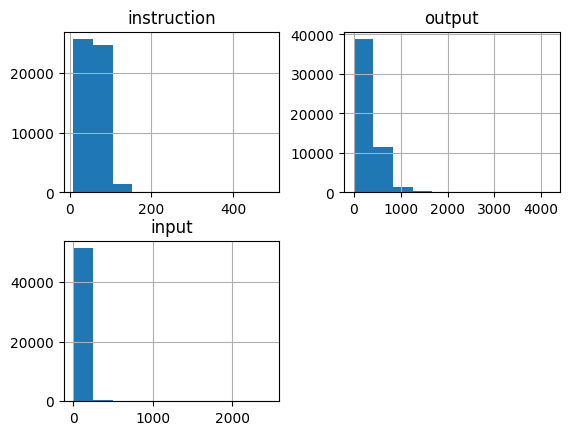

In [37]:
dataset.data[["instruction", "output", "input"]].map(len).hist();

### Preprocessing

To customize preprocessing behavior, we can override the appropriate method:
- `BaseMapDataset.__getitem__` for fully custom behavior, multi-modal, multi-task, etc.
- `BaseMapDataset.preprocess_items` for custom preprocessing of standard datasets (inputs, labels)
- `BaseSftDataset.preprocess_items` To customize preprocessing, tokenization of a standard SFT dataset
- `BaseSftDataset.format_inputs` To transform raw data row into lema conversation
- `LemaSftDataset` -> If raw data already in Lema format, no custom class needed!

In [7]:
dataset = AlpacaDataset(tokenizer=tokenizer)

print(f"Using: {dataset.dataset_name_or_path}")

Using: tatsu-lab/alpaca


In [15]:
%%timeit

dataset.raw(0)

5.6 µs ± 17.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [16]:
%%timeit

dataset.conversation(0)

13.8 µs ± 65.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [17]:
%%timeit

dataset.prompt(0)

25.4 µs ± 81.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%%timeit

dataset[0]

315 µs ± 4.11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## 6. Comparing with other datasets

In [33]:
import datasets

In [34]:
hf_dataset = datasets.load_dataset("yahma/alpaca-cleaned")
hf_dataset = hf_dataset["train"]

#### Raw Random Access

In [35]:
%%timeit

dataset.raw(0)  # use lema dataset random access

5.66 µs ± 56 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [36]:
%%timeit

hf_dataset[0]  # use huggingface dataset random access

14.6 µs ± 246 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [37]:
%%timeit

hf_dataset.data[0]  # directly access the arrow table

504 ns ± 5.03 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


#### With Tokenization

In [ ]:
%%timeit

# Arrow
dataset.tokenize(hf_dataset.data[0])

118 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit

# HF Datasets
dataset.tokenize(hf_dataset[0])

40 µs ± 205 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
%%timeit

# HF Datasets
dataset[0]

314 µs ± 4.13 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
%%timeit

# Lema dataset
dataset.tokenize(dataset.raw(0))

44.4 µs ± 573 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [23]:
%%timeit

# Full lema pipeline
dataset[0]

316 µs ± 8.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Iterate over dataset

In [ ]:
%%timeit

# Manual iteration
[dataset[i] for i in range(len(dataset))];

In [ ]:
%%timeit

# With a pytorch data loader
loader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
list(loader);

In [40]:
%prun [dataset[i] for i in range(len(dataset))];

         21800369 function calls (21748606 primitive calls) in 23.434 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    51760   14.265    0.000   14.265    0.000 {method 'encode_batch' of 'tokenizers.Tokenizer' objects}
   103520    1.456    0.000    1.456    0.000 {built-in method torch.tensor}
        1    0.396    0.396   23.434   23.434 <string>:1(<module>)
   207040    0.367    0.000    0.611    0.000 {method 'validate_python' of 'pydantic_core._pydantic_core.SchemaValidator' objects}
  4547145    0.355    0.000    0.575    0.000 {built-in method builtins.isinstance}
   207040    0.259    0.000    0.294    0.000 enum.py:686(__call__)
   226197    0.197    0.000    0.719    0.000 series.py:1085(__getitem__)
   155280    0.190    0.000    0.294    0.000 sandbox.py:125(is_internal_attribute)
    51760    0.182    0.000   19.989    0.000 tokenization_utils_base.py:1684(apply_chat_template)
    51760    0.181    0.000    

In [43]:
%lprun -f dataset.__getitem__ [dataset[i] for i in range(len(dataset))];

Timer unit: 1e-09 s

Total time: 21.6536 s
File: /Users/oussamaelachqar/source/lema/lema/src/lema/core/types/base_dataset.py
Function: __getitem__ at line 51

Line #      Hits         Time  Per Hit   % Time  Line Contents
    51                                               def __getitem__(self, idx: int) -> Union[Conversation, dict]:
    52                                                   """Gets the item at the specified index.
    53                                           
    54                                                   Args:
    55                                                       idx (int): The index of the item to retrieve.
    56                                           
    57                                                   Returns:
    58                                                       dict: The item at the specified index.
    59                                                   """
    60     51760 1041049000.0  20113.0      4.8          sample = se

In [45]:
%memit [dataset[i] for i in range(len(dataset))]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


peak memory: 3034.42 MiB, increment: 317.41 MiB


## 7. Benchmark with Model Forward Pass

In [27]:
%%time

model = AutoModelForCausalLM.from_pretrained("gpt2")

/Users/oussamaelachqar/miniconda3/envs/dev/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


CPU times: user 928 ms, sys: 1.59 s, total: 2.52 s
Wall time: 706 ms


In [28]:
loader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)

In [34]:
%%timeit

# Including pre-processing
# Excluding pre-processing
with torch.no_grad():
    batch = next(iter(loader))
    model.forward(**batch)

77.5 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
fixed_batch = next(iter(loader))

In [33]:
%%timeit

# Excluding pre-processing
with torch.no_grad():
    model.forward(**fixed_batch)

77.2 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
